### Roof Segmentation using PyTorch

Notebook created by: Leonard Wetzel

**Content:**
* We train a deep neural network (based on the Unet architecture, see below) to perform a satellite image segmentation task. We assume to have a very small dataset (below 30 satellite images) of low resolution (256x256 pixels each) satellite images and 25 corresponding labels that indicate the roofs of the houses in black/white (segmentation), we want the network to learn creating this segmentation itself, and then test our trained network on the remaining 5 validation images.

* The model in this notebook was trained on a non-public set of images, it will be updated soon to some publicly available images

* We make use of the PyTorch toolkit together with the segmentation_models_pytorch library that provides us with several predefined models for image segmentation. We employ data augmentation with the Albumentations library to artificially increase the size of the training set.

* The network architecture of choice as well as all other ingredients/techniques used to build our model will be explained briefly throughout the notebook.

* We use a Google Collab environment in order to carry out the training on a fast GPU.

#### Setup

When inside a Google Collab notebook, install the segmentation_models_pytorch package by executing the following cell:

In [ ]:
!pip install segmentation_models_pytorch

#### Import libraries

In [64]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold

from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Configuration
Define the different file paths containing the images and labels, the device we want to train our model on (CUDA) and the encoder architecture of our network as well as the pre-trained weights.

In [ ]:
# Define image and label directories
IMAGES_DIR = '/content/drive/MyDrive/Colab Notebooks/images'
LABELS_DIR = '/content/drive/MyDrive/Colab Notebooks/labels'

# Select the device to train on
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define pretrained encoder model and weights
ENCODER = 'resnet34'
WEIGHTS = 'imagenet'

#### Dataset
We define a RoofDataset subclass of the PyTorch dataset class which will store our data.

We use the [cv2](https://pypi.org/project/opencv-python/) library (OpenCV) for loading the images and labels/masks into a numpy array containing the corresponding pixel values.

In [7]:
class RoofDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        # Load RGB image into numpy ndarray of shape (256, 256, 3)
        img = cv2.imread(self.image_paths[i], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load corresponding mask as single-channel grayscale (0-255) numpy ndarray
        mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
        # Convert to binary (0: background, 1: roof)
        mask = (mask > 127).astype(np.uint8)

        # If a transformation in the data augmentation process is applied, replace by the transformed versions
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        else:
            img = torch.from_numpy(img.transpose(2,0,1))
            mask = torch.from_numpy(mask)

        return img.float(), mask.float().unsqueeze(0)

#### Data augmentation
We are provided with a dataset containing only 25 pictures. Using data augmentation, we are able to increase the size of our training dataset by randomly applying transformations to the images used in training. The Albumentations library provides a very convenient way to implement this.
- The training data is augmented randomly by various transformation
- Both training and validation images must be normalized as we use the resnet34 encoder pre-trained on the imagenet dataset, where the training data was normalized with mean $(0.485,0.456,0.406)$ and standard deviation $(0.229,0.224,0.225)$.
- `ToTensorV2()` converts the final images to torch tensors.

In [70]:
# Transformations applied to training data
def get_train_augs():
    train_tfms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.07, rotate_limit=20,
                           border_mode=cv2.BORDER_REFLECT_101, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    return train_tfms

# Transformations applied to validation data (only normalization and conversion to the right data type)
def get_val_augs():
    val_tfms = A.Compose([
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
    return val_tfms

#### Model, loss functions and metrics
We use a [U-Net architecture](https://arxiv.org/abs/1505.04597) with a resnet34 encoder pre-trained on imagenet data. As loss function, we employ a combination of DiceLoss with binary cross-entropy.
- Cross-entropy: penalizes wrong pixel-wise classifications.
- Dice loss: tries to make up for the problem of large class imbalance by optimizing for region overlap.
  
Finally, we use both Dice and IoU (intersection over union) to measure the performance of our model.

In [9]:
def build_model():
    return smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3, # 3 color channels (RGB)
        classes=1, # binary segmentation (roof vs background)
        activation=None
    )

def bce_dice_loss():
    bce = nn.BCEWithLogitsLoss() # combination of BCE and sigmoid layer for computational efficiency
    dice = smp.losses.DiceLoss(mode='binary')
    def loss_fn(logits, masks):
        return 0.5 * bce(logits, masks) + 0.5 * dice(logits, masks)
    return loss_fn

@torch.no_grad()
def iou_dice_from_preds(preds, targets, thresh=0.5, eps=1e-7):
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    iou = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / (preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps)
    return iou.mean().item(), dice.mean().item()

#### Assessment of model performance

We start by defining functions for training and validation of one training epoch...

In [83]:
# Function for training of one epoch

def train_one_epoch(model, loader, opt, scaler, device, scheduler=None):
    model.train() # Put model in training mode (affects frozen weights)
    total_loss = 0.0
    for imgs, msks in tqdm(loader, leave=False):
        imgs, msks = imgs.to(device), msks.to(device)
        opt.zero_grad(set_to_none=True)
        with autocast(device):
            logits = model(imgs)
            loss_fn = bce_dice_loss()
            loss = loss_fn(logits, msks)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        # step OneCycleLR per batch
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()*imgs.size(0)
    return total_loss/len(loader.dataset)

# Function for validation of one epoch

@torch.no_grad()
def valid_one_epoch(model, loader, device, thr=0.5):
    model.eval() # Put model in validation mode

    total_loss = 0.0

    total_iou = 0.0
    total_dice = 0.0
    total_n = 0

    total_loss = 0.0
    for imgs, msks in loader:
        imgs, msks = imgs.to(device), msks.to(device)
        logits = model(imgs)
        loss_fn = bce_dice_loss()
        loss = loss_fn(logits, msks)
        total_loss += loss.item() * imgs.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs > thr).float()

        iou, dice = iou_dice_from_preds(preds, msks)
        bs = imgs.size(0)
        total_iou += iou * bs
        total_dice += dice * bs
        total_n += bs

    val_loss = total_loss / total_n
    mean_iou = total_iou / total_n
    mean_dice = total_dice / total_n

    return val_loss, mean_iou, mean_dice


...and now want to use cross validation to assess our model's performance. To that end, we define a function that
performs $K$-fold CV given $K$, the batch size, the maximum amount of epochs and the learning rate.

We have the choice between different optimization algorithms and schedulers.
* Optimization: Popular choices include stochastic gradient descent (SGD), Adam, AdamW (the latter two are sophisticated modifications of the SGD algorithm by not just using the gradient of the current step but also keep track of previous updates).
* Scheduling: Allows for adjustment of the learning rate during training. We use the [OneCycleLR scheduler](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR): *The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate.*

In [84]:
def run_cv(pairs, n_splits=5, batch_size=4, max_epochs=60, lr=1e-3):
    kf = KFold(n_splits=n_splits, shuffle=True)

    fold_results = []
    val_loss_history = {}

    for fold, (tr_idx, va_idx) in enumerate(kf.split(pairs), 1):
        print(f"\n=== Fold {fold}/{n_splits} ===")
        train_images = [pairs[i][0] for i in tr_idx]
        train_masks = [pairs[i][1] for i in tr_idx]
        valid_images = [pairs[i][0] for i in va_idx]
        valid_masks = [pairs[i][1] for i in va_idx]
        train_ds = RoofDataset(train_images, train_masks, transform=get_train_augs())
        valid_ds = RoofDataset(valid_images, valid_masks, transform=get_val_augs())
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

        # --- Optimization settings ---

        model = build_model().to(DEVICE)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        steps_per_epoch = max(1, len(train_dl))
        sched = torch.optim.lr_scheduler.OneCycleLR(
            opt,
            max_lr=lr,
            epochs=max_epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.1, # percentage of the cycle spent increasing the learning rate
            div_factor=25.0, # determines initial learning rate
            final_div_factor=1e4 # determines minimum learning rate
        )
        scaler = GradScaler(DEVICE)

        # --- train this fold ---
        thr = 0.5

        best_iou, best_state = -1, None
        patience, patience_ctr = 25, 0

        val_loss_history[fold] = []

        for epoch in range(1, max_epochs+1):
            tr_loss = train_one_epoch(model, train_dl, opt, scaler, DEVICE, sched)

            val_loss, iou, dice = valid_one_epoch(model, valid_dl, DEVICE, thr)
            val_loss_history[fold].append(val_loss)
            print(f"[Fold {fold}] Epoch {epoch:02d} | train {tr_loss:.4f} | val {val_loss:.4f} | IoU {iou:.4f} | Dice {dice:.4f} | thr {thr:.2f}")

            if iou > best_iou:
                best_iou = iou
                best_state = model.state_dict()
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    break

        fold_results.append((best_iou, best_state))


    mean_iou = np.mean([r[0] for r in fold_results])
    print(f"\nCV mean IoU: {mean_iou:.4f}")
    return fold_results, val_loss_history

Finally, we actually carry out the cross validation.

In [ ]:
# Helper function returning all image/mask pairs
def list_pairs(img_dir=IMAGES_DIR, msk_dir=LABELS_DIR):
    imgs = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    pairs, unlabeled = [], []
    for f in imgs:
        m = os.path.join(msk_dir, f)
        if os.path.exists(m):
            pairs.append((os.path.join(img_dir,f), m))
        else:
            unlabeled.append(os.path.join(img_dir,f))
    return pairs, unlabeled

# Get all image/mask pairs
pairs, unlabeled = list_pairs()
print(f"Labeled pairs: {len(pairs)} | Unlabeled(test) images: {len(unlabeled)}")

# Run CV
fold_results, val_hist = run_cv(pairs, n_splits=5, batch_size=4, max_epochs=60, lr=1e-3)

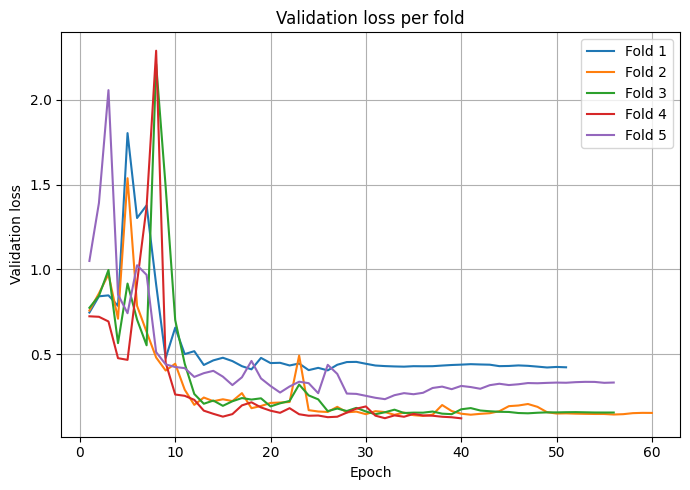

In [86]:
plt.figure(figsize=(7,5))
for fold, losses in val_hist.items():
    plt.plot(range(1, len(losses)+1), losses, label=f"Fold {fold}")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss per fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We see that generally after ~ $30$ epochs, the validation loss within each split stabilizes. Also after several tests $0.50$ seems like a good threshold.

#### Fit the final model

After playing around a bit with the settings (batch sizes, epochs, patience and optimizer/scheduler) we now fit our model to the full set of 25 training images.

In [92]:
def refit_and_save(pairs, batch_size=4, max_epochs=40, lr=1e-3, out_ckpt="roof_resnet34_unet.pth"):

    train_images = [p[0] for p in pairs]
    train_masks = [p[1] for p in pairs]

    train_ds = RoofDataset(train_images, train_masks, transform=get_train_augs())
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

    model = build_model().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    steps_per_epoch = max(1, len(train_dl))

    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=lr, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
        pct_start=0.1, div_factor=25.0, final_div_factor=1e4
    )

    scaler = GradScaler(DEVICE)

    best_loss, best_state = 1e9, None
    for epoch in range(1, max_epochs+1):
        tr_loss = train_one_epoch(model, train_dl, opt, scaler, DEVICE, sched)
        print(f"[REFIT] Epoch {epoch:02d} | train loss {tr_loss:.4f}")
        if tr_loss < best_loss:
            best_loss = tr_loss
            best_state = model.state_dict()

    torch.save(best_state, out_ckpt)
    print(f"Saved: {out_ckpt}")
    return out_ckpt

To get more robust predictions on a single image, we perform test-time augmentation, i.e. running the model on horizontally, vertically and horizontally+vertically flipped versions of the same image. The predictions are then flipped back to the original orientation and averaged together to smooth out model noise.

In [67]:
@torch.no_grad()
def predict_tta(model, img, device, thr=0.5):
    # img: tensor [1,3,H,W] normalized
    logits = model(img)
    # TTA: hflip + vflip
    logits_h = model(torch.flip(img, dims=[-1]))
    logits_v = model(torch.flip(img, dims=[-2]))
    logits_hv= model(torch.flip(img, dims=[-1,-2]))
    logits_avg = (logits + torch.flip(logits_h, dims=[-1]) + torch.flip(logits_v, dims=[-2]) + torch.flip(logits_hv, dims=[-1,-2])) / 4.0
    probs = torch.sigmoid(logits_avg)
    return (probs > thr).float(), probs

def infer_unlabeled(ckpt, thr, out_dir="preds"):
    os.makedirs(out_dir, exist_ok=True)
    model = build_model().to(DEVICE)
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    model.eval()

    test_imgs = sorted([p for p in os.listdir(IMAGES_DIR) if not os.path.exists(os.path.join(LABELS_DIR,p))])
    aug = get_val_augs()
    for f in test_imgs:
        path = os.path.join(IMAGES_DIR, f)
        img = cv2.imread(path, cv2.IMREAD_COLOR)[:,:,::-1]
        sample = aug(image=img)
        ten = sample['image'].unsqueeze(0).to(DEVICE)
        pred_bin, pred_prob = predict_tta(model, ten, DEVICE, thr=thr)
        m = (pred_bin.squeeze().cpu().numpy()*255).astype('uint8')
        cv2.imwrite(os.path.join(out_dir, f), m)
        print(f"Wrote {os.path.join(out_dir,f)}")

In [93]:
pairs, unlabeled = list_pairs()
thr_star = 0.5  # determined by CV earlier
ckpt = refit_and_save(pairs, batch_size=4, max_epochs=30, lr=1e-3)
infer_unlabeled(ckpt, thr=thr_star)

[REFIT] Epoch 01 | train loss 0.7353


[REFIT] Epoch 02 | train loss 0.6546


[REFIT] Epoch 03 | train loss 0.5335


[REFIT] Epoch 04 | train loss 0.4418


[REFIT] Epoch 05 | train loss 0.3887


[REFIT] Epoch 06 | train loss 0.3289


[REFIT] Epoch 07 | train loss 0.3333


[REFIT] Epoch 08 | train loss 0.2887


[REFIT] Epoch 09 | train loss 0.2599


[REFIT] Epoch 10 | train loss 0.2708


[REFIT] Epoch 11 | train loss 0.2566


[REFIT] Epoch 12 | train loss 0.2273


[REFIT] Epoch 13 | train loss 0.2216


[REFIT] Epoch 14 | train loss 0.2029


[REFIT] Epoch 15 | train loss 0.1922


[REFIT] Epoch 16 | train loss 0.1886


[REFIT] Epoch 17 | train loss 0.1765


[REFIT] Epoch 18 | train loss 0.1780


[REFIT] Epoch 19 | train loss 0.1991


[REFIT] Epoch 20 | train loss 0.1678


[REFIT] Epoch 21 | train loss 0.1604


[REFIT] Epoch 22 | train loss 0.1560


[REFIT] Epoch 23 | train loss 0.1363


[REFIT] Epoch 24 | train loss 0.1597


[REFIT] Epoch 25 | train loss 0.1409


[REFIT] Epoch 26 | train loss 0.1464


[REFIT] Epoch 27 | train loss 0.1384


[REFIT] Epoch 28 | train loss 0.1415


[REFIT] Epoch 29 | train loss 0.1547


[REFIT] Epoch 30 | train loss 0.1435
Saved: roof_resnet34_unet.pth
Wrote preds/535.png
Wrote preds/537.png
Wrote preds/539.png
Wrote preds/551.png
Wrote preds/553.png


#### Summary
We have trained a image segmentation model to detect roofs on satellite images without much finetuning. To improve the performance our model further, we could
- play around with the random transformations from the Albumentations library,
- try different optimization algorithms and parameters,
- try different learning rate schedulers,
- try different loss functions and weights
- and much more.